# $Rayleigh$


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

### Fixed parameters


In [7]:
# Constants
num_iter = 10000  # Number of Monte Carlo iterations
N = 2 # No of NOMA users
S = 4096  # Sampled length
a1, a2 = 0.8, 0.2  # Power allocations
Pf = 0.1  # False-alarm probability
env_SNRs_dB = np.arange(
    -25, 6, 1
)  # Range of environmental SNR values to iterate through
transmitter_power = 1

### Lists to store results


In [8]:
Pds = []  # List to store detection probabilities
TPRs = []  # List to store true positive rates

In [9]:
def rician_channel(K):
    
    # LOS Component
    h_LOS = np.sqrt(K / (1 + K))
    
    # NLOS Component
    real = np.random.normal(0, np.sqrt(0.5 / (1 + K)))
    imag = np.random.normal(0, np.sqrt(0.5 / (1 + K)))
    h_NLOS = real + 1j * imag

    # Total channel coefficient
    h = h_LOS + h_NLOS

    return h

### Monte Carlo simulation


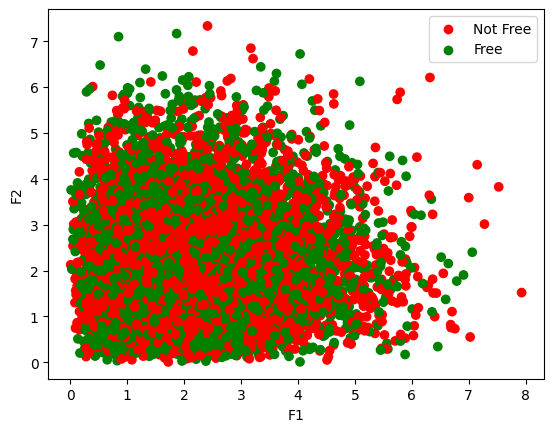

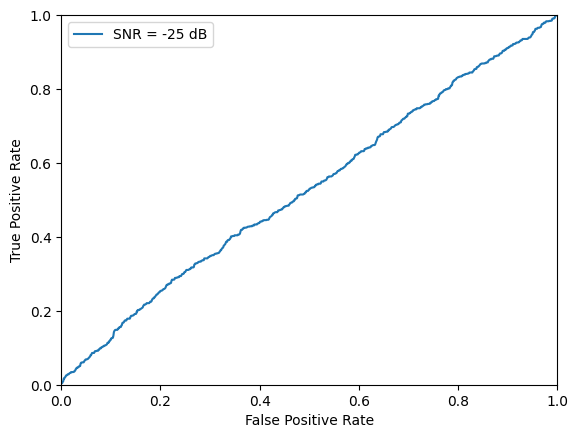

SNR: -25 dB Probability of detection: 0.11604641856742696 fTPR at 0.1 FPR: 0.1220703125


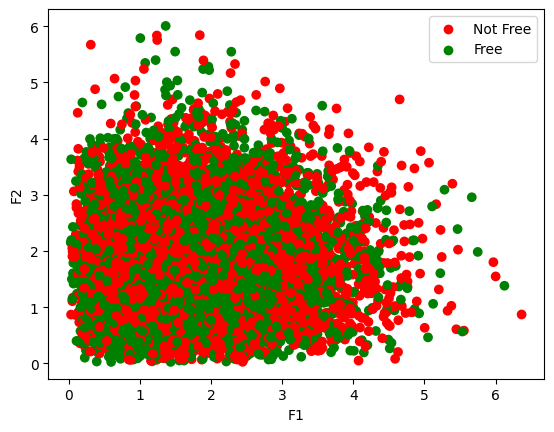

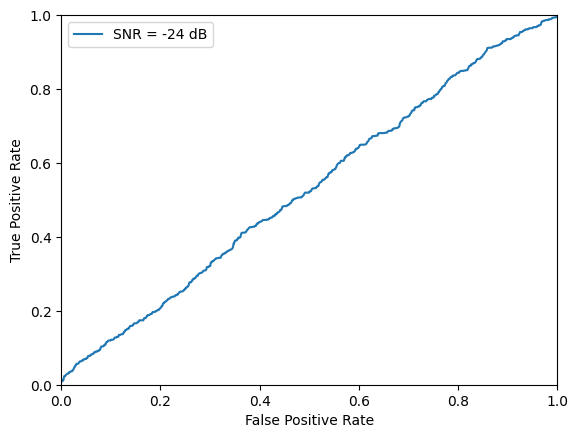

SNR: -24 dB Probability of detection: 0.12210822772078053 fTPR at 0.1 FPR: 0.12158054711246201


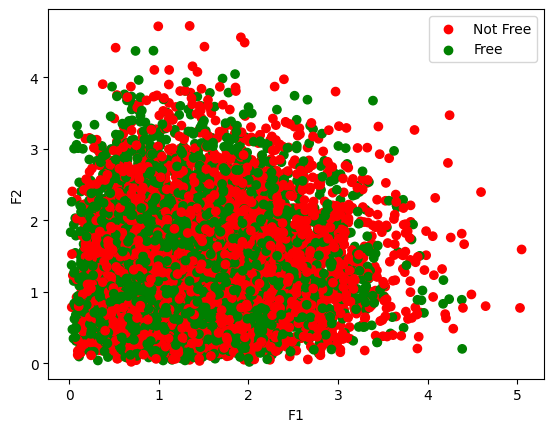

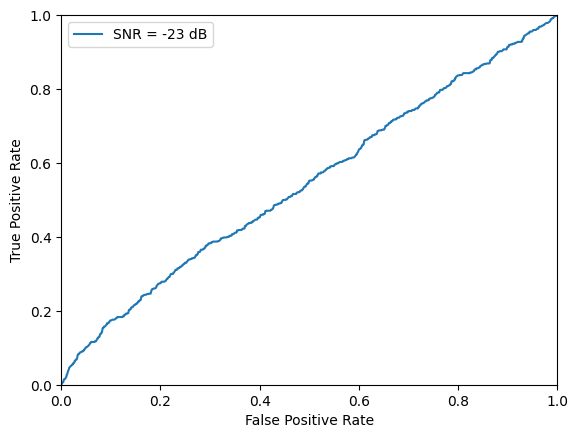

SNR: -23 dB Probability of detection: 0.1283570300157978 fTPR at 0.1 FPR: 0.17404426559356137


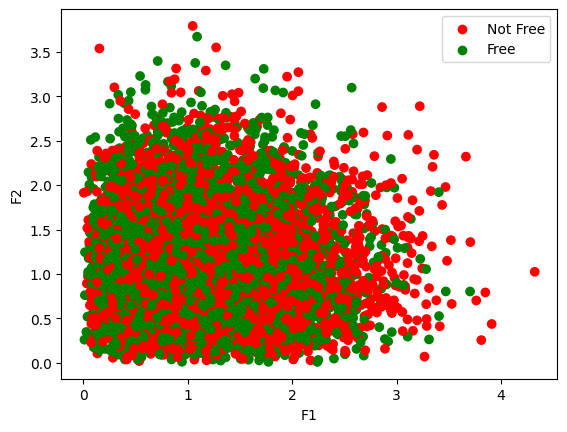

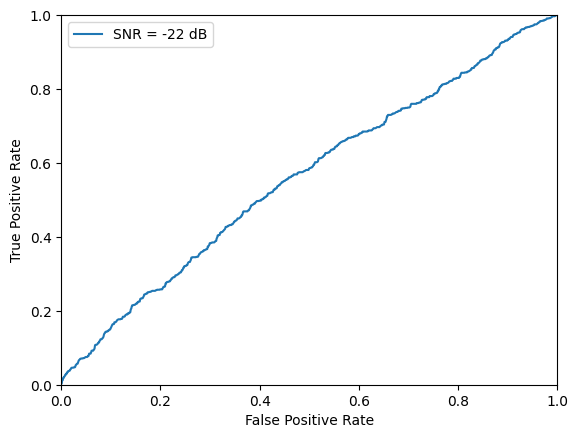

SNR: -22 dB Probability of detection: 0.13113451221935227 fTPR at 0.1 FPR: 0.154


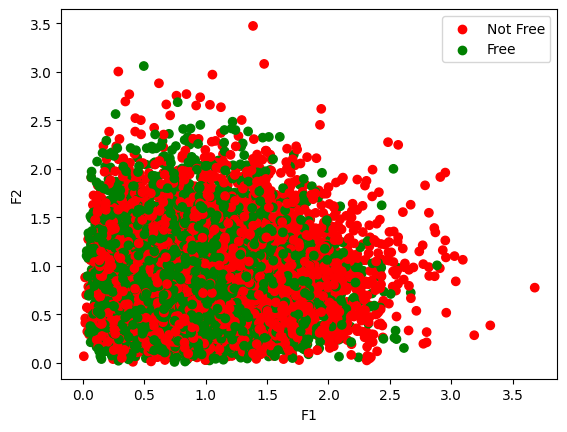

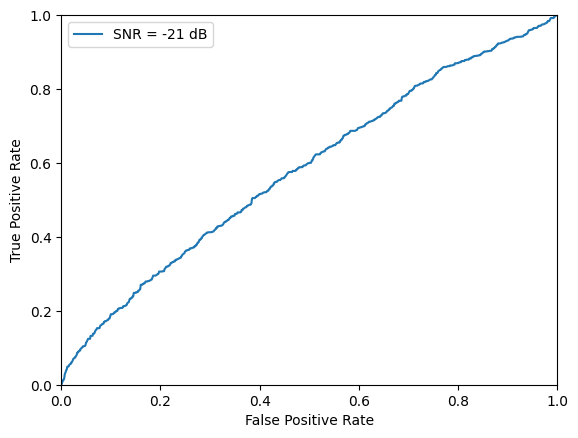

SNR: -21 dB Probability of detection: 0.14520328459843782 fTPR at 0.1 FPR: 0.1908548707753479


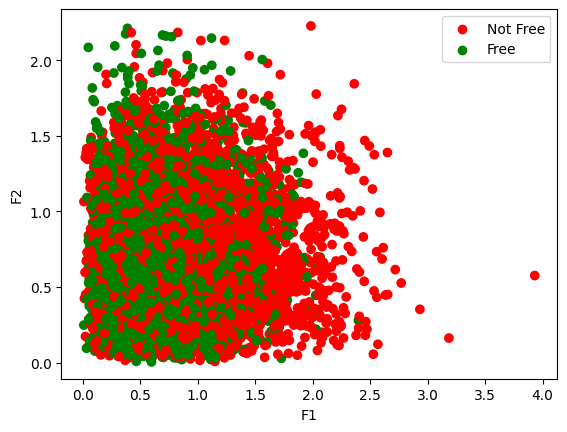

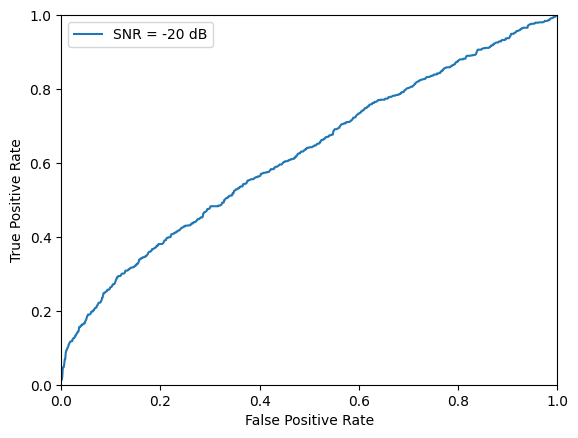

SNR: -20 dB Probability of detection: 0.1771777690185258 fTPR at 0.1 FPR: 0.2638753651411879


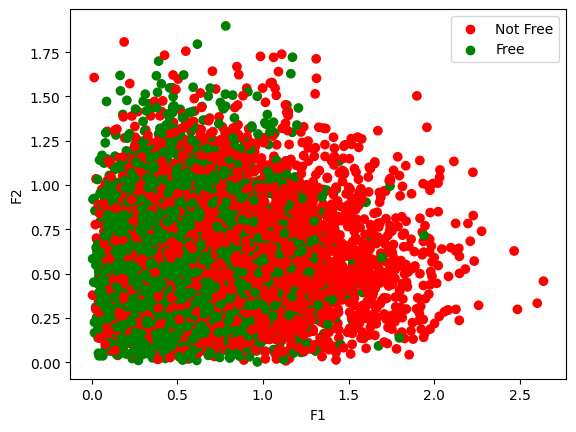

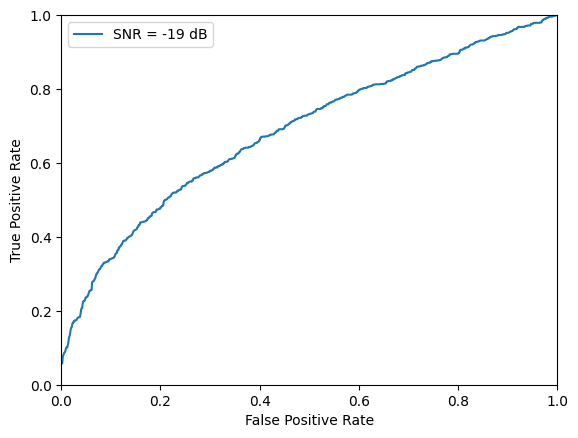

SNR: -19 dB Probability of detection: 0.1963029937713482 fTPR at 0.1 FPR: 0.34063745019920316


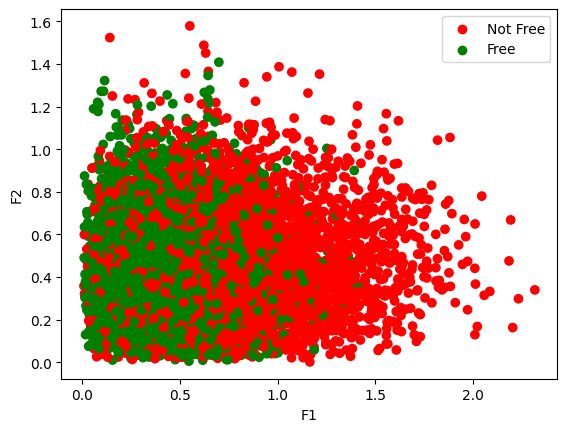

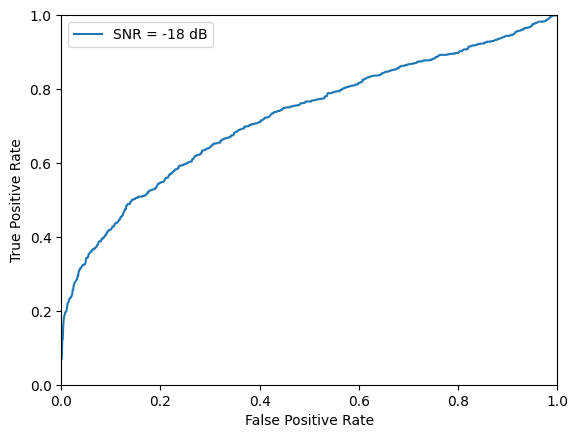

SNR: -18 dB Probability of detection: 0.2288647342995169 fTPR at 0.1 FPR: 0.42110453648915186


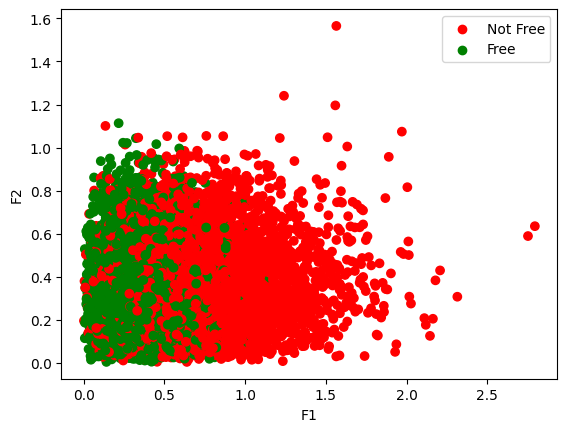

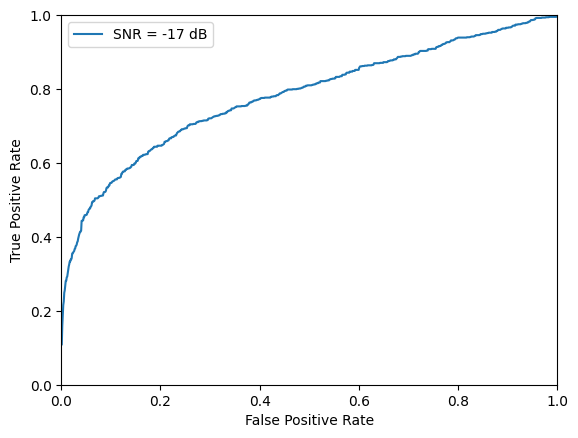

SNR: -17 dB Probability of detection: 0.27262021589793917 fTPR at 0.1 FPR: 0.5460588793922128


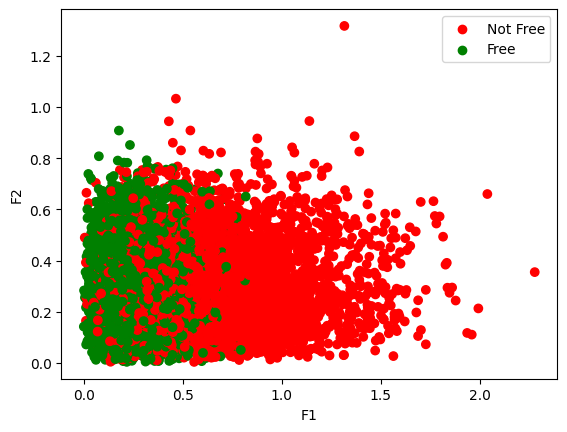

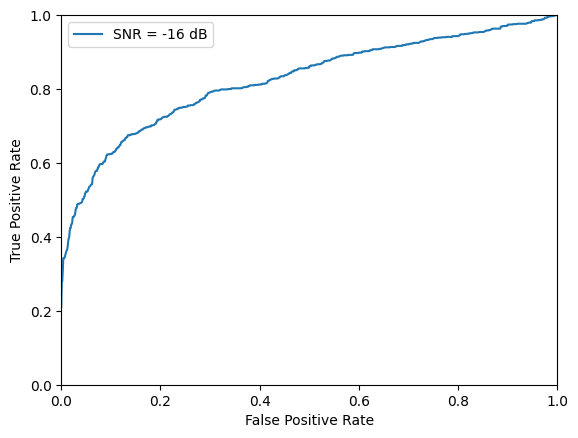

SNR: -16 dB Probability of detection: 0.30942334739803096 fTPR at 0.1 FPR: 0.6243654822335025


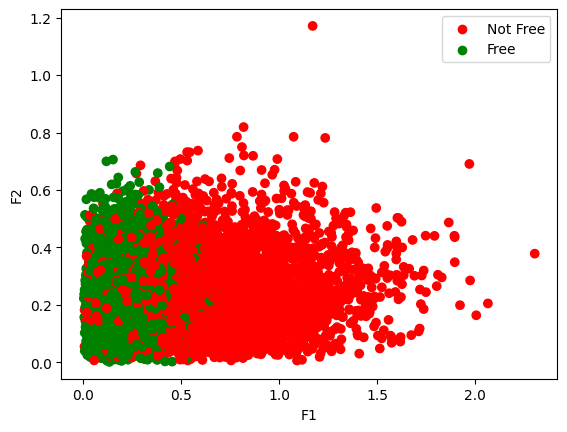

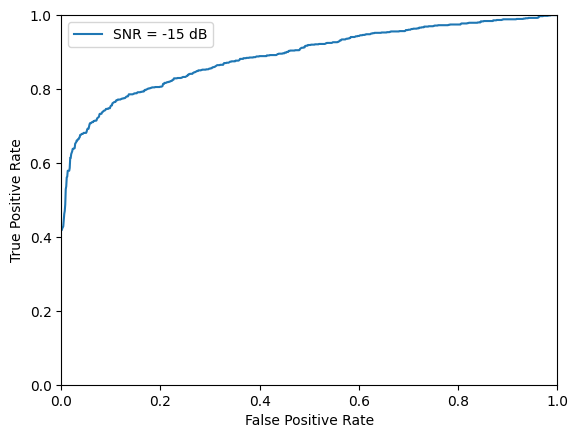

SNR: -15 dB Probability of detection: 0.3377742946708464 fTPR at 0.1 FPR: 0.7546992481203008


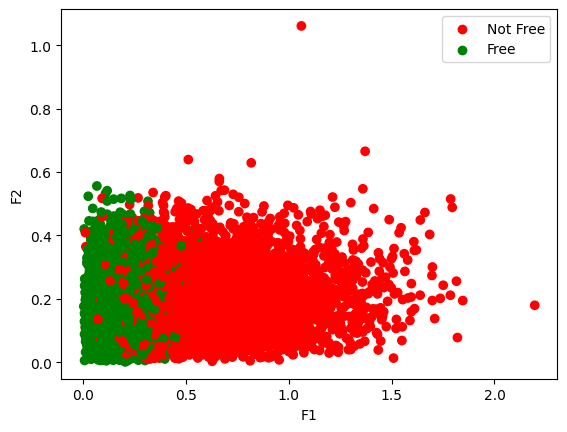

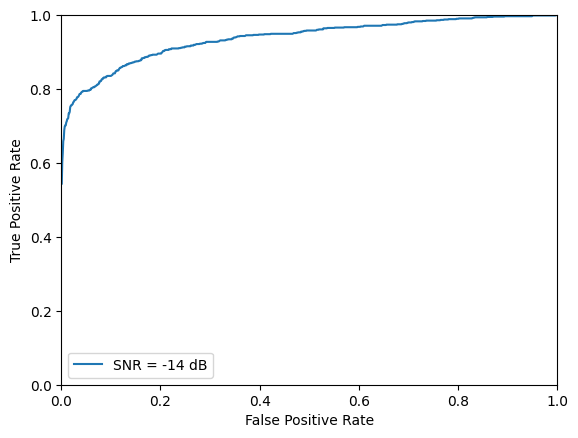

SNR: -14 dB Probability of detection: 0.3672270609681993 fTPR at 0.1 FPR: 0.8354806739345887


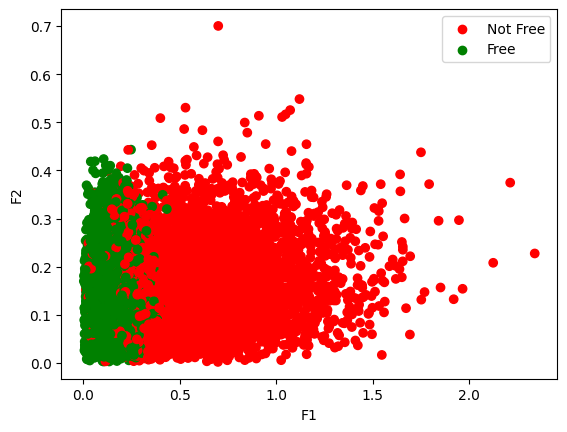

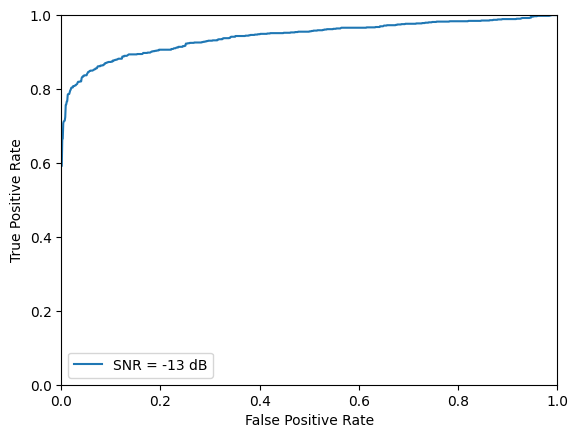

SNR: -13 dB Probability of detection: 0.40342924714229406 fTPR at 0.1 FPR: 0.8732943469785575


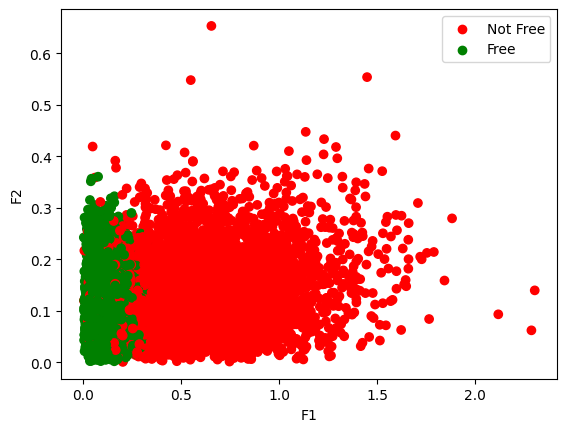

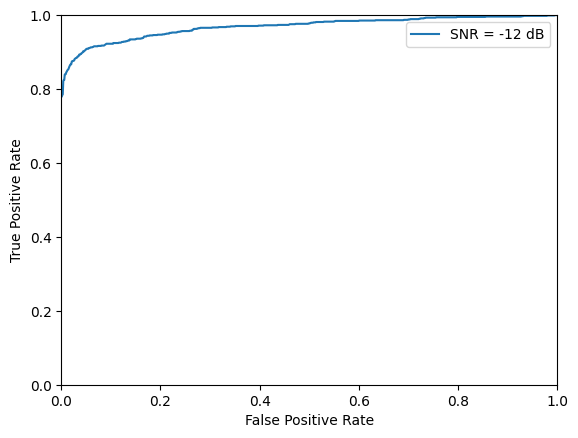

SNR: -12 dB Probability of detection: 0.44326807830603276 fTPR at 0.1 FPR: 0.9225490196078432


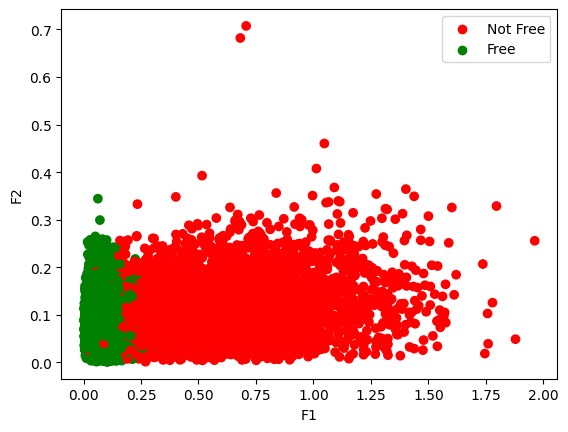

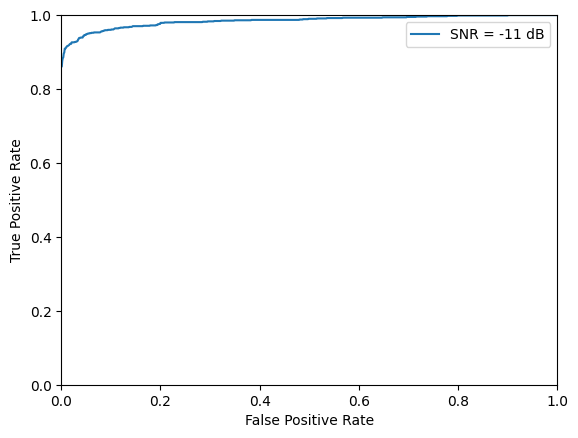

SNR: -11 dB Probability of detection: 0.47985273061975864 fTPR at 0.1 FPR: 0.9601990049751243


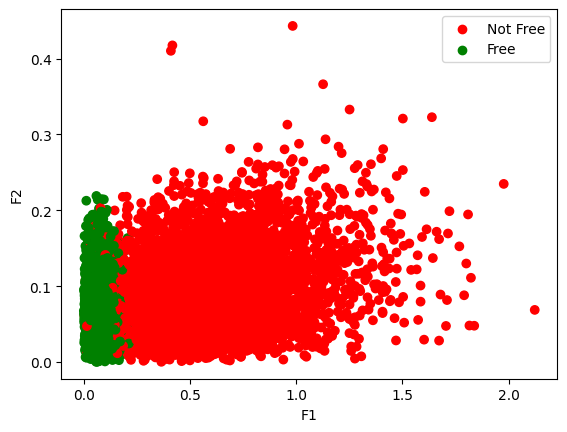

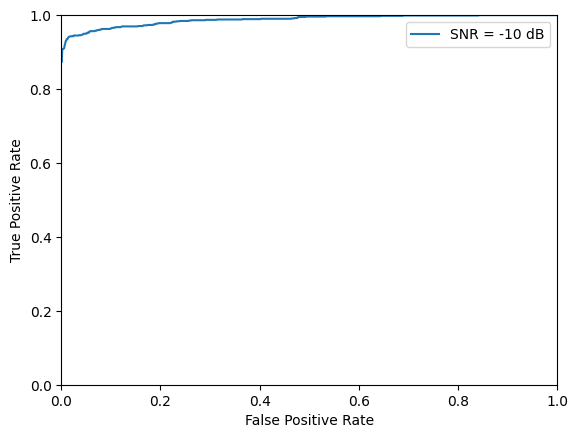

SNR: -10 dB Probability of detection: 0.5255112169942426 fTPR at 0.1 FPR: 0.9635467980295567


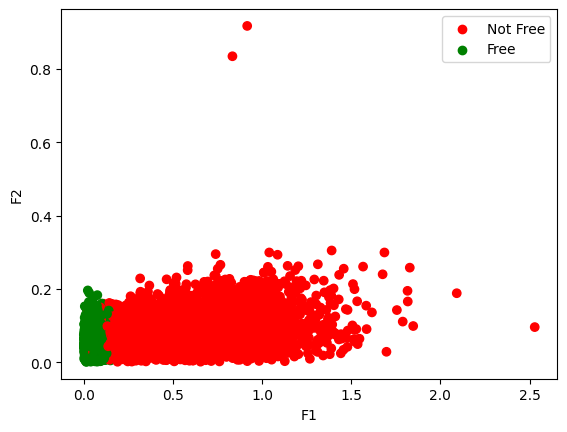

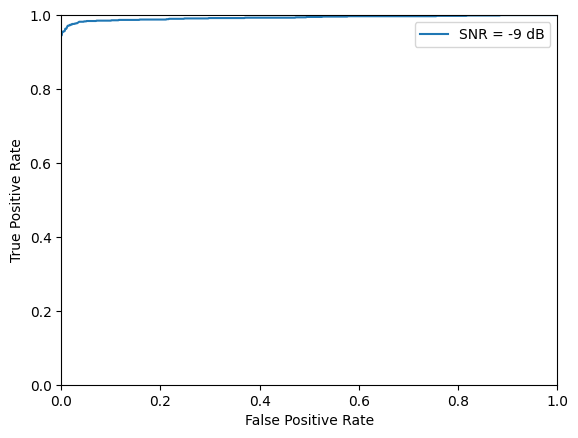

SNR: -9 dB Probability of detection: 0.5706304868316041 fTPR at 0.1 FPR: 0.9850597609561753


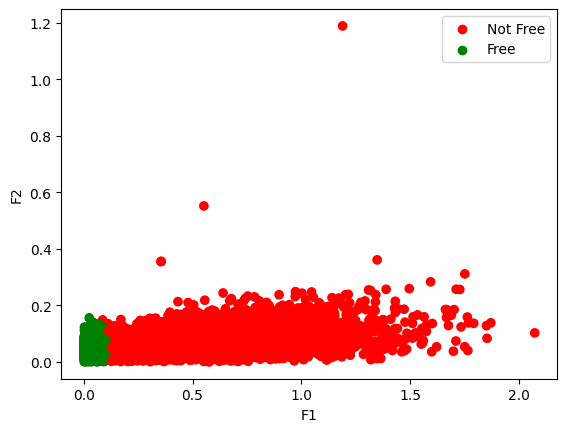

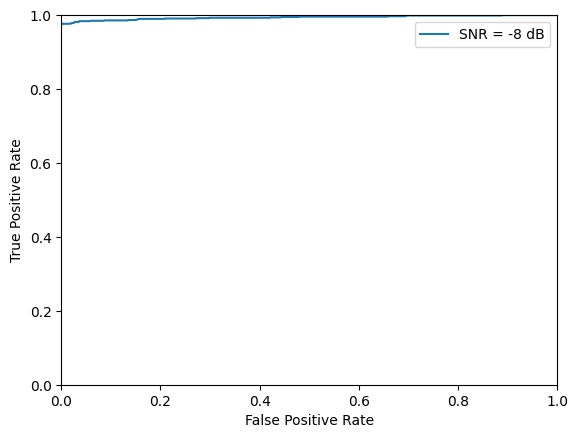

SNR: -8 dB Probability of detection: 0.6304477611940299 fTPR at 0.1 FPR: 0.9857288481141692


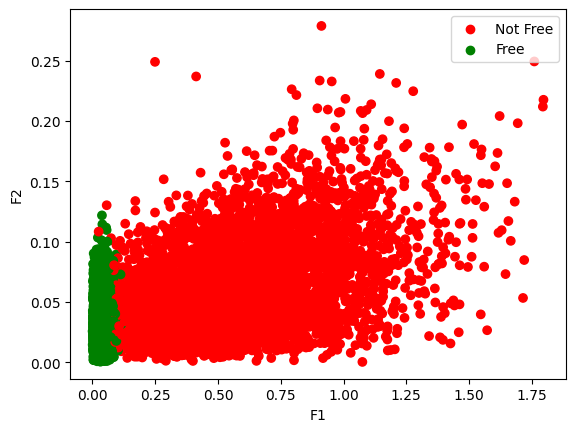

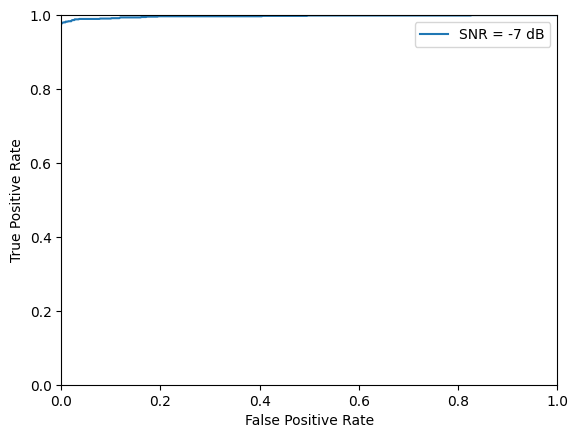

SNR: -7 dB Probability of detection: 0.6818732337505047 fTPR at 0.1 FPR: 0.9906832298136646


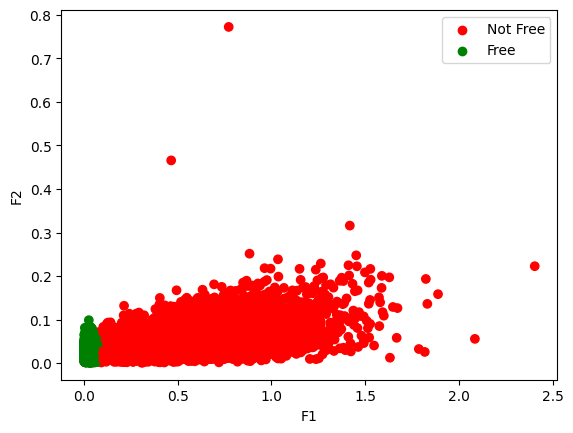

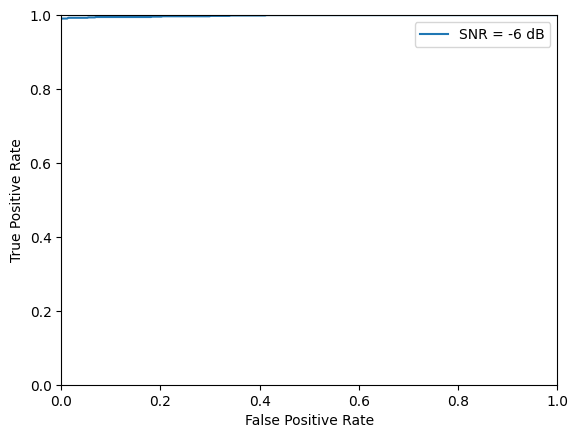

SNR: -6 dB Probability of detection: 0.7313948759658397 fTPR at 0.1 FPR: 0.9948453608247423


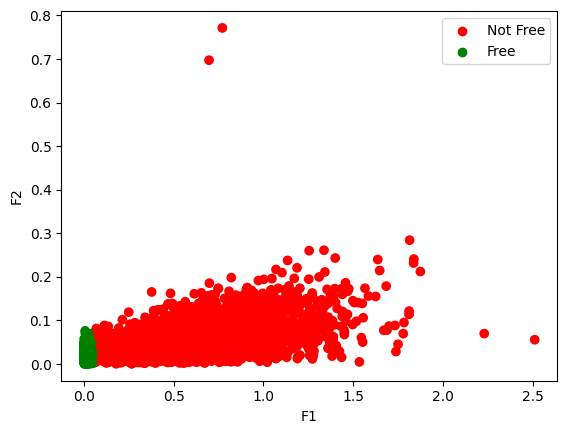

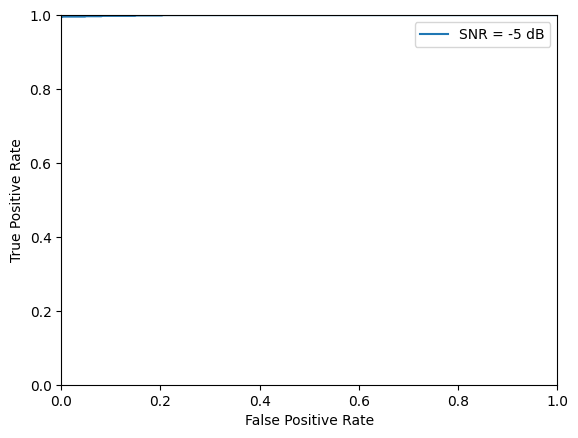

SNR: -5 dB Probability of detection: 0.7968500797448166 fTPR at 0.1 FPR: 0.9979859013091642


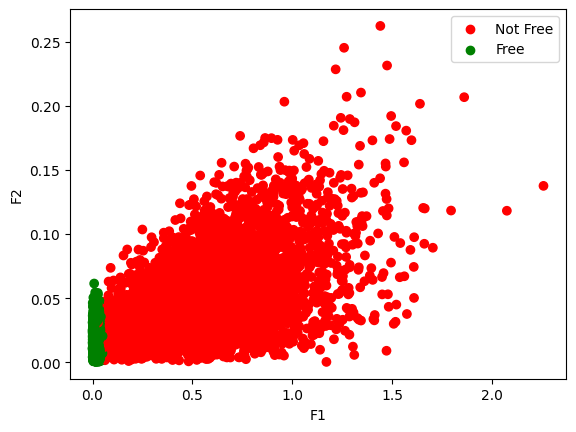

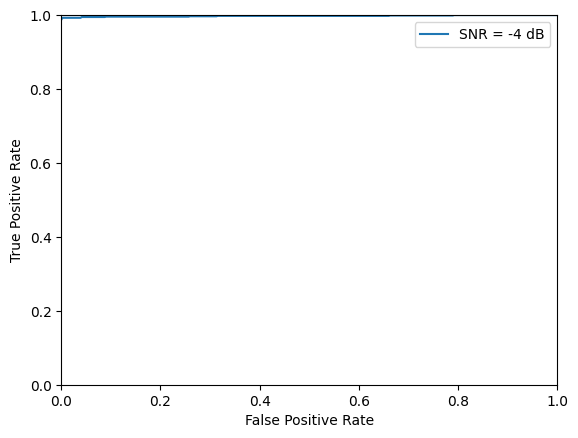

SNR: -4 dB Probability of detection: 0.8308096103371694 fTPR at 0.1 FPR: 0.9958720330237358


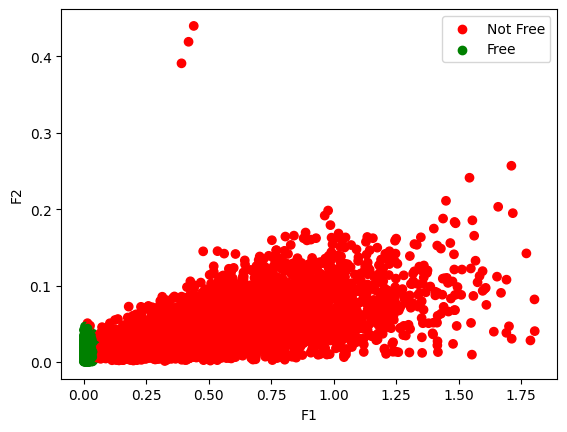

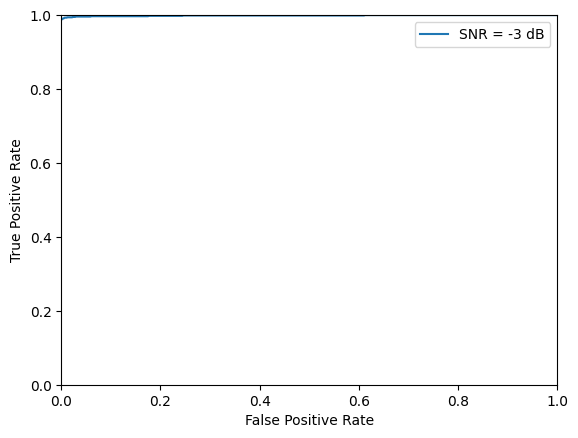

SNR: -3 dB Probability of detection: 0.8704494610534879 fTPR at 0.1 FPR: 0.9970501474926253


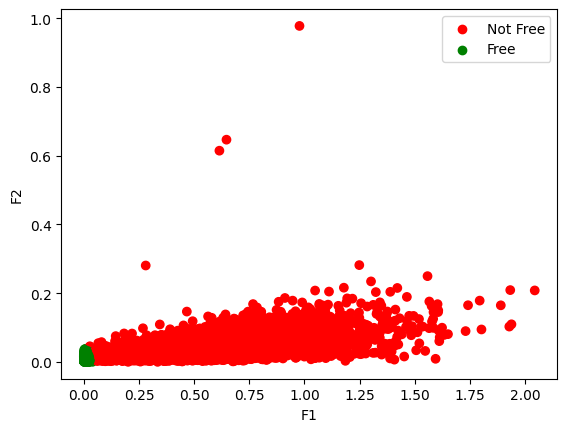

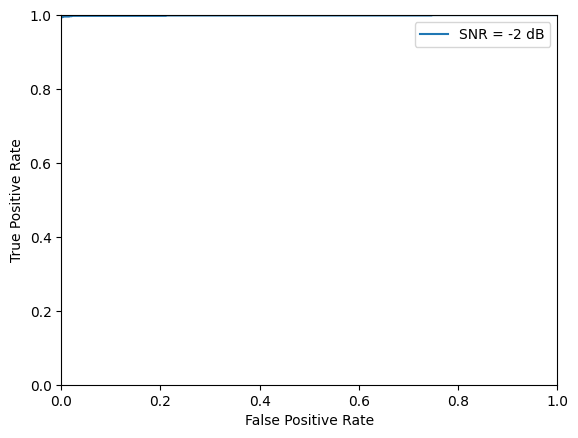

SNR: -2 dB Probability of detection: 0.9011361371337453 fTPR at 0.1 FPR: 0.9980676328502416


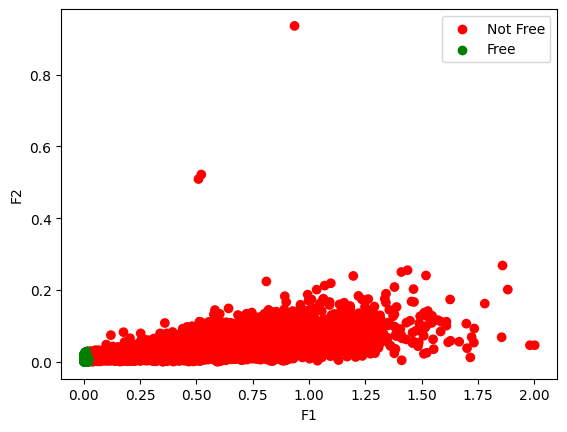

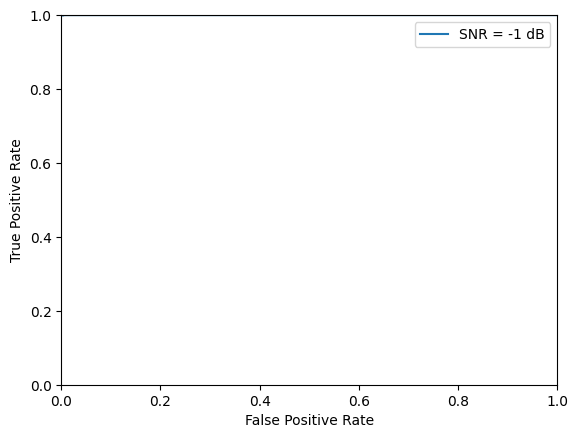

SNR: -1 dB Probability of detection: 0.9294730514926869 fTPR at 0.1 FPR: 1.0


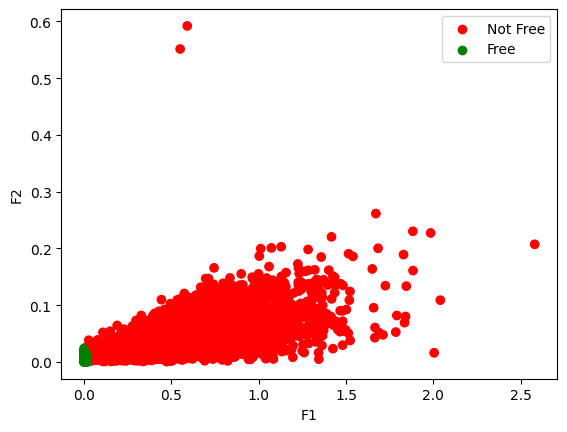

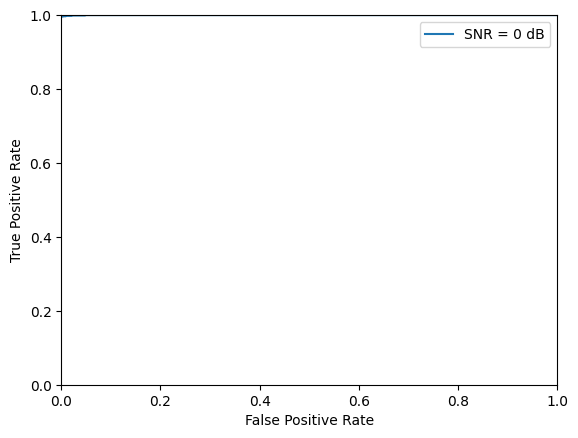

SNR: 0 dB Probability of detection: 0.9516487962775643 fTPR at 0.1 FPR: 1.0


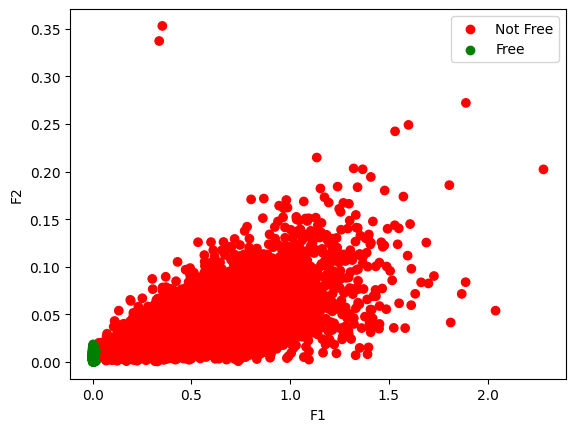

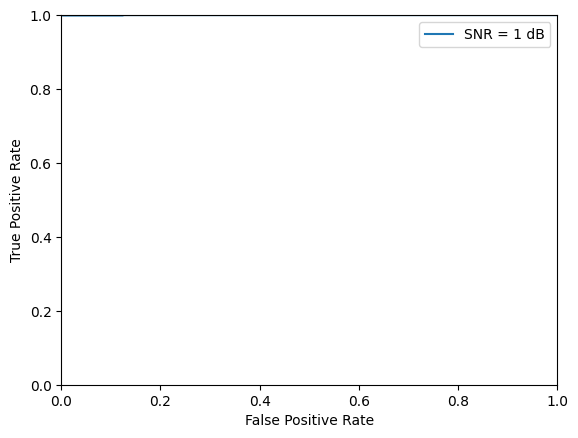

SNR: 1 dB Probability of detection: 0.9645929185837168 fTPR at 0.1 FPR: 0.9989868287740629


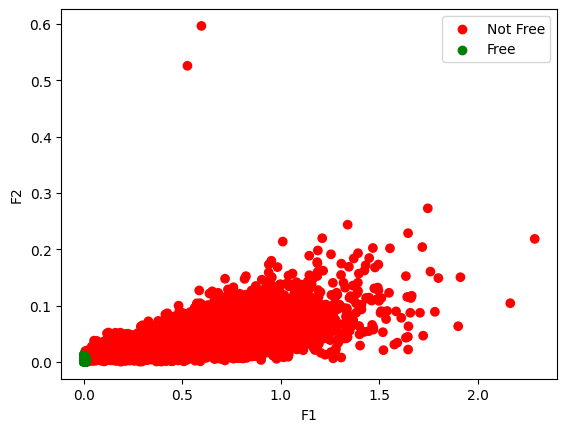

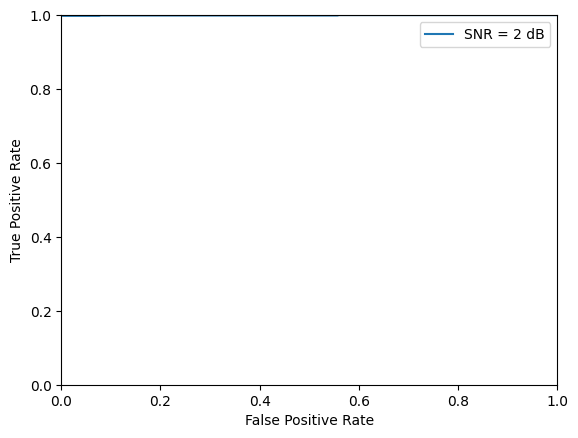

SNR: 2 dB Probability of detection: 0.9751233958538993 fTPR at 0.1 FPR: 0.9990205680705191


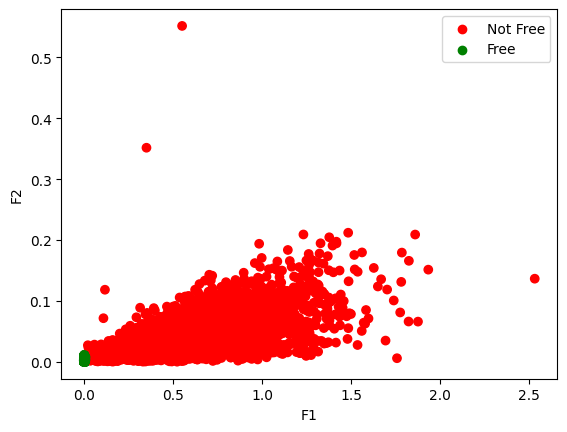

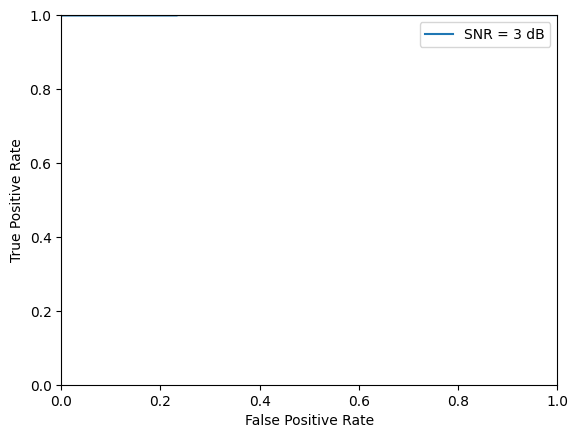

SNR: 3 dB Probability of detection: 0.9827482447342026 fTPR at 0.1 FPR: 0.9990384615384615


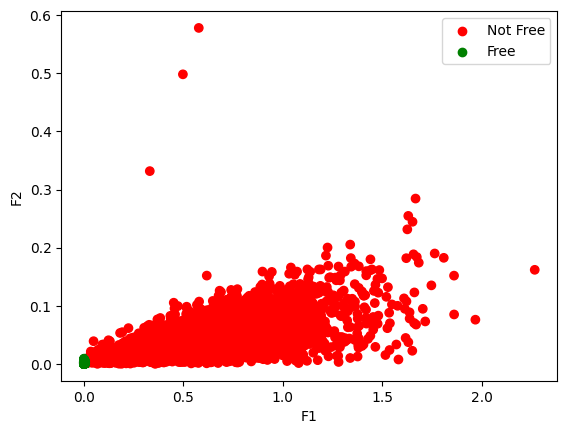

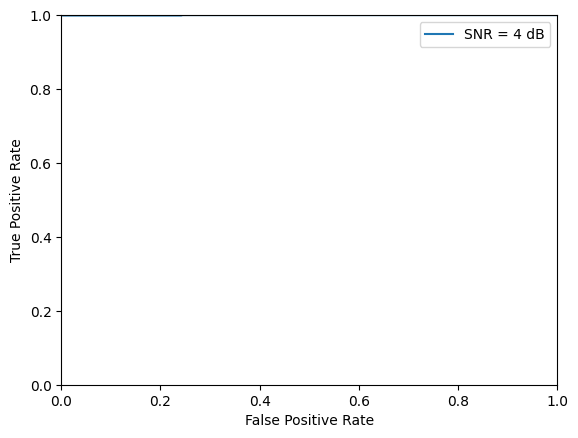

SNR: 4 dB Probability of detection: 0.9878 fTPR at 0.1 FPR: 0.9989827060020345


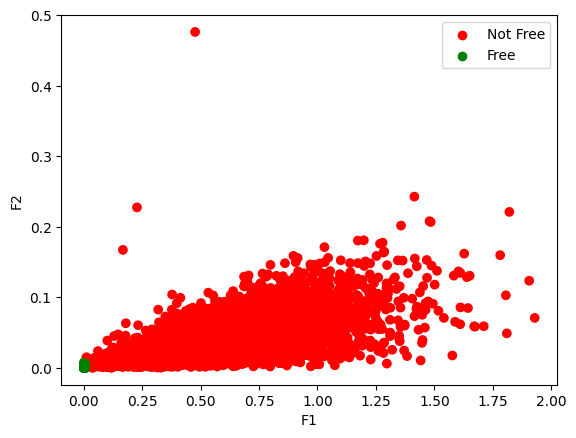

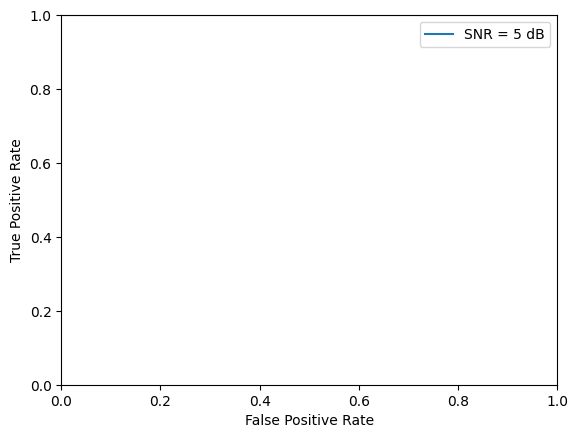

SNR: 5 dB Probability of detection: 0.9905451619392477 fTPR at 0.1 FPR: 1.0


In [10]:
for env_SNR_dB in env_SNRs_dB:
    # Convert SNR from dB to linear scale
    env_SNR_linear = transmitter_power * 10 ** (env_SNR_dB / 10)

    # Noise standard deviation based on environmental SNR
    N0 = np.sqrt(1 / (2 * env_SNR_linear))

    # Threshold for AND joint user decision
    lambda_AND = (np.sqrt(-np.log(Pf) / (N * S))) * (N0**2)

    # Monte Carlo simulation
    total_transmit = 0
    successful_detection = 0
    false_alarm_count = 0

    F = []

    for _ in range(num_iter):
        # Random cyclic delays
        d1, d2 = np.random.randint(1, S, 2)

        K = 3  # Example K-factor value
        h1 = rician_channel(K)
        h2 = rician_channel(K)

        # 50% chance that BS1 will transmit signal
        transmit = np.random.rand() < 0.5

        if transmit:
            total_transmit += 1

            # Generating signals for user 1 and user 2
            x1_n = np.random.randn(S)
            x2_n = np.random.randn(S)

            # Combining signals to produce t1 and t2
            t1_n = a1 * x1_n + a2 * x2_n
            t2_n = a1 * np.roll(x1_n, d1) + a2 * np.roll(x2_n, d2)

            # Rayleigh distributed complex normal noise
            noise_std_dev = N0 * np.sqrt(1 / 2)
            noise = noise_std_dev * (np.random.randn(S) + 1j * np.random.randn(S))

            # Final sent signal
            r_n = h1 * t1_n + h2 * t2_n + noise

            # Cyclic correlation processing
            F_delta1 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d1)))) / S
            F_delta2 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d2)))) / S

            F.append({"F1": F_delta1, "F2": F_delta2, "transmit": 1})

            # Decision
            if F_delta1 > lambda_AND and F_delta2 > lambda_AND:
                successful_detection += 1

        if not transmit:
            # Generating noise only
            noise_std_dev = N0 * np.sqrt(1 / 2)
            noise = noise_std_dev * (np.random.randn(S) + 1j * np.random.randn(S))
            r_n = noise

            # Cyclic correlation processing
            F_delta1 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d1)))) / S
            F_delta2 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d2)))) / S

            F.append({"F1": F_delta1, "F2": F_delta2, "transmit": 0})

            # Decision
            if F_delta1 > lambda_AND and F_delta2 > lambda_AND:
                false_alarm_count += 1

    # Probability of detection
    Pd = successful_detection / total_transmit if total_transmit > 0 else 0
    Pds.append(Pd)

    # Convert F to DataFrame
    F = pd.DataFrame(F)
    X = F[["F1", "F2"]]
    y = F["transmit"]

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Divide the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y, test_size=0.2, random_state=42
    )

    # Classifier
    clf = LogisticRegression(random_state=42, max_iter=1000)

    # Train the Classifier
    clf.fit(X_train, y_train)

    # Define the desired FPR
    desired_fpr = 0.1

    # ROC curve plotting
    y_probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Create an interpolation function using the FPR and TPR values
    interp_tpr = interp1d(fpr, tpr)

    # Define a new set of FPR values for the interpolated curve
    new_fpr = np.linspace(0, 1, 1000)

    # Use the interpolation function to find the TPR for the new FPR values
    new_tpr = interp_tpr(new_fpr)

    # TPR at desired FPR
    tpr = interp_tpr(desired_fpr)
    TPRs.append(tpr)
    
    colors = ["red" if t == 1 else "green" for t in F["transmit"]]

    plt.figure()
    scatter_red = plt.scatter([], [], c='red', label='Not Free')
    scatter_green = plt.scatter([], [], c='green', label='Free')

    # This will display the actual data
    plt.scatter(F["F1"], F["F2"], c=colors)

    plt.xlabel("F1")
    plt.ylabel("F2")
    plt.legend(handles=[scatter_red, scatter_green])

    plt.show()
    
    # Plot the interpolated curve
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot(new_fpr, new_tpr, label=f"SNR = {env_SNR_dB} dB")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()  # Adding legends
    plt.show()

    print(
        f"SNR: {env_SNR_dB} dB Probability of detection: {Pd} fTPR at {desired_fpr} FPR: {tpr}"
    )

### Convert lists to numpy arrays


In [11]:
Pds = np.array(Pds)
TPRs = np.array(TPRs)

### Plotting Probability of detection vs Environmental SNR


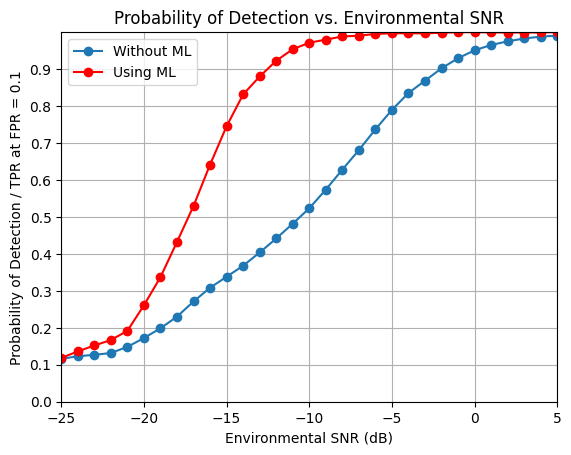

In [12]:
from scipy.signal import savgol_filter

plt.figure()

# Smooth the graph of Pds
Pds_smooth = savgol_filter(Pds, window_length=5, polyorder=3)
TPRs_smooth = savgol_filter(TPRs, window_length=5, polyorder=3)

plt.yticks(np.arange(0, 1, 0.1))
plt.ylim(0, 1)
plt.xlim(-25, 5)

# Plot the smoothed Probability of Detection vs. Environmental SNR
plt.plot(env_SNRs_dB, Pds_smooth, marker="o", label="Without ML")
plt.plot(env_SNRs_dB, TPRs_smooth, marker="o", color="red", label="Using ML")

plt.title("Probability of Detection vs. Environmental SNR")
plt.xlabel("Environmental SNR (dB)")
plt.ylabel("Probability of Detection / TPR at FPR = 0.1")
plt.grid(True)
plt.legend()
plt.show()